# ResNet 구조

ResNet 모델은 총 다섯 개의 모델 유형을 제공한다.  
1개의 입력 줄기(input stem)와  4개의 스테이지(stage)로 구성된다.  
<br>
input stem은 아래의 구조로 구성된다.
1. 7x7 합성곱 계층(convolution layer)
2. 배치 정규화(Batch Regularization)
3. ReLU
4. 3x3 Max pooling  

stage는 여러 개의 잔차 블록(Residual Block)으로 구성된다.  
<br>
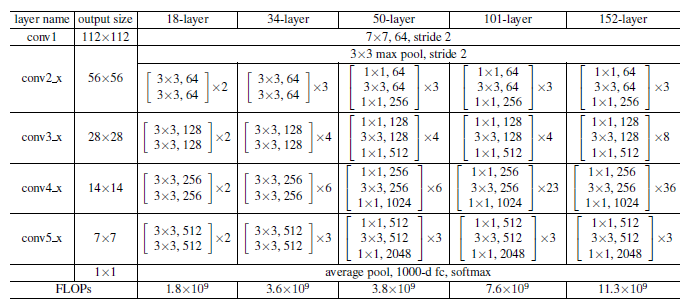

# 기본 블록
ResNet-18, ResNet-34에서 사용하는 기본 블록.  
3x3 CL(Convolution Layer), BN, ReLU를 두 번 반복해 연결한 구조를 갖는다.  
레즈넷은 하나의 스테이지 안에서 블록이 여러번 반복되는 구조이므로 모듈화해 기본 블록 클래스를 구현한다.

In [1]:
from torch import nn

class BasicBlock(nn.Module):
  expansion = 1 # 출력 채널 수가 중간 채널 수(planes)에 비해 얼마나 확장되는지 비율

  def __init__(self, inplanes, planes, stride=1): # inplanes, planes: 입력, 출력 채널 수
    super().__init__()
    self.conv1 = nn.Conv2d(
        inplanes, planes,
        kernel_size=3, stride=stride, padding=1, bias=False
    )
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(
        planes, planes,
        kernel_size=3, stride=1, padding=1, bias=False
    )
    self.bn2 = nn.BatchNorm2d(planes)

    # skip connection
    self.shortcut = nn.Sequential()
    if stride != 1 or inplanes != self.expansion*planes: # 입/출력 채널 수가 다르다면,
      self.shorcut = nn.Sequential(                      # 1x1 conv로 크기와 채널을 맞춘 뒤 BN 적용
          nn.Conv2d(
              inplanes, self.expansion*planes,
              kernel_size=1, stride=stride, bias=False
          ),
          nn.BatchNorm2d(self.expansion*planes)
      )

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.shortcut(x) # 입력값을 더해 잔차 연결 수행
    out = self.relu(out)
    return out

conv 출력의 채널마다 정규화(평균 0, 분산 1)해서 학습 안정화를 위해 bn을 바로 뒤에 적용한다.  
shortcut은 입력값을 출력값에 더해 활성화해서 별다른 연산을 적용하지 않으므로 비어 있는 sequential을 생성해 잔차 연결 변수로 사용한다.  
<br>
**잔차 연결 단계에서 입출력 채널 수가 다를 때 1x1 conv을 적용하는 이유:**  
output = F(x) + x  
위의 수식처럼 입력 x를 블록의 출력 F(x)와 더하고 싶은데, 이를 위해선 두 텐서의 shape이 같아야 한다.  
이때 1x1 conv는 공간을 건드리지 않으면서 채널 변환만 담당할 수 있다.  
따라서 1x1 conv의 출력 채널 수를 planes*expansion 으로 지정해서 입력값 x의 shape을 출력값 F(x)의 shape과 동일하게 맞춘다.

# 병목 블록(Bottleneck Block)
병목 블록은 기본 블록과 유사하지만, 더 많은 CL을 사용하며, 마지막 1x1 CL에서 특정 맵의 차원 수를 확장(expansion)하는 방식을 사용한다.  
즉, 1x1 conv로 차원을 줄이고, 3x3 conv를 수행한 후, 다시 1x1 conv로 원래 차원으로 복원하는 3개의 CL을 사용한다.  
병목 블록의 목표는 **연산량 줄이기!!**

In [2]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
      super().__init__()
      self.conv1 = nn.Conv2d( # 1x1 conv로 차원 줄이기
          inplanes, planes,
          kernel_size=1, bias=False
      )
      self.bn1 = nn.BatchNorm2d(planes)
      self.conv2 = nn.Conv2d( # 3x3 conv 계산
          planes, planes,
          kernel_size=3, stride=stride, padding=1, bias=False
      )
      self.bn2 = nn.BatchNorm2d(planes)
      self.con3 = nn.Conv2d( # 1x1 conv로 다시 차원 원상복귀
          planes, self.expansion*planes,
          kernel_size=1, bias=False
      )
      self.bn3 = nn.BatchNorm2d(self.expansion*planes)
      self.relu = nn.ReLU(inplace=True)

      # 잔차 연결
      self.shorcut = nn.Sequential()
      if stride != 1 or inplace != expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(
                inplanes, self.expansion*planes,
                kernel_size=1, stride=stride, bias=False
            ),
            nn.BatchNorm(self.expansion*planes)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

expansion=4로 3번째 conv에서 출력 차원 수를 높여 모델의 복잡도와 매개변수의 수를 조절한다.

# ResNet 모델
앞에서 구현한 기본 블록, 병목 블록이 여러 번 반복해 하나의 stage를 구성한다.  
그러므로 여러 블록을 묶는 스테이지 메서드를 구성해 레즈넷 모델을 구현한다.

In [5]:
import torch

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential( # 입력 이미지(3채널 RGB)를 받아 초기 특징 추출
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # 공간 정보를 1×1로 압축
        self.fc = nn.Linear(512 * block.expansion, num_classes) # 최종 분류 출력

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride)) # 첫 블록
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

**self.stem**: 입력부  
- Conv2(7x7, stride=2): 큰 커널로 이미지를 크게 훑으며 초반 특징 추출, stride=2 -> 해상도 절반으로 감소  
- Maxpool(3x3, stride=2): 다시 한 번 다운샘플링 -> 전체적으로 4배 축소(H, W / 4)  
<br>

**_make_layer()**: 블록을 여러 개 쌓는 함수  
- 특정 stage를 구성한다.  
- block을 몇 개 쌓을지, 첫 블록에서 stride로 다운샘플링을 할지를 지정한다.  
<br>

**forward()**: 순전파  
1. stem: 7x7 conv + pool
2. stage1-4: 점점 더 깊고 채널 수 많은 피처 맵 추출
3. AdaptiveAvgPool2d(1,1): 입력 크기에 상관없이 1x1로 축소(global pooling)  
=> 전역 평균풀링 (공간정보 요약)  
(C,H,W) -> (C,1,1)   
4. flatten: (N,C,1,1) -> (N,C)
5. FC Layer: 분류 결과